## In this notebook we will impute Pressure variable of the WRF data. We have saprately fetched the data from 2019-05-01 to 2019-05-31 in pickel files. 

## The location we will focus is UMBC in Maryland

## The data will be divided in 70% training and 30% testing, ie Model will be roughly trained on first 20 days and evalute on next 10 days.

In [1]:
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import autokeras as ak
from math import sqrt
from tensorflow.keras.regularizers import l2, l1
import time
from mpl_toolkits.basemap import Basemap
import argparse
import matplotlib as mpl

### Retreiving data from Pickel file

In [2]:
datafile = open('PickleDataFiles/wrfout_d01_2019_05_01_to_2019_05_31_TPWHNO', 'rb')      
data = pickle.load(datafile) 

### For this notebook we will focus on 'latitude', 'longitude', 'Pressure' variables

In [3]:
data.keys()

dict_keys(['times', 'latitude', 'longitude', 'temperature', 'xWind', 'yWind', 'zWind', 'pressure', 'no2', 'no', 'o3', 'hno3', 'h2o2'])

### Among all the latitude longitude points, these points near UMBC

In [4]:
#'UMBC'
print(data['latitude'][17][20])
print(data['longitude'][17][20])

39.589718
-76.512085


In [5]:
print('times :' + str(len(data['times'])))
print('Lat :' + str(data['latitude'].shape))
print('Lon :' + str(data['longitude'].shape))
print('Pressure :' + str(data['pressure'].shape))
print('Temperature :' + str(data['temperature'].shape))

times :744
Lat :(29, 29)
Lon :(29, 29)
Pressure :(744, 29, 29, 29)
Temperature :(744, 29, 29, 29)


- We can see above that total we have 29*29 Latitude and Longitude Points
- We have 744 data point for a month ie, we have data for each hour (31*24 = 744)
- For Temperature and Pressure we have 29 level of the data and at each level we have 29*29 gird points at each lat-lon point

### Next we will retrieve all the 29 level data point of all the variables at UMBC. Storing them to respective list

In [4]:
lat_loc=17
lon_loc=20
temperature =[]
pressure = []
xWind = []
yWind = []
zWind = []
no2 = []
no = []
o3 = []
hno3 = []
h2o2 = []
for i in range(len(data['temperature'])):
    temperature.append(data['temperature'][i][lat_loc][lon_loc])
    pressure.append(data['pressure'][i][lat_loc][lon_loc])
    xWind.append(data['xWind'][i][lat_loc][lon_loc])
    yWind.append(data['yWind'][i][lat_loc][lon_loc])
    zWind.append(data['zWind'][i][lat_loc][lon_loc])
    no2.append(data['no2'][i][lat_loc][lon_loc])
    no.append(data['no'][i][lat_loc][lon_loc])
    o3.append(data['o3'][i][lat_loc][lon_loc])
    hno3.append(data['hno3'][i][lat_loc][lon_loc])
    h2o2.append(data['h2o2'][i][lat_loc][lon_loc])
    

### As this is time series data so first thing came to mind is to use RNN. A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step. 
### This is Univariate RNN model, so our input and output variable are both Pressure.
### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [5]:

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            print("break")
            print(i)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Emulating Pressure

### This is Univariate RNN model, so our input and output variable are both Pressure.
### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [57]:
X_pressure,y_pressure=split_sequence(pressure, 3)

break
741


In [58]:
y_pressure.shape

(741, 29)

In [59]:
#standard Deviation of the data
np.std(y_pressure)

104.65278

### Splitting the data with test size of 33 %

In [60]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pressure, y_pressure, test_size=0.33, random_state=42)

### In order to make the model learning easy, lets standardise the input data

In [61]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_p = scaler.fit_transform(X_train_p.reshape(X_train_p.shape[0], -1)).reshape(X_train_p.shape)


In [62]:
X_test_p = scaler.fit_transform(X_test_p.reshape(X_test_p.shape[0], -1)).reshape(X_test_p.shape)

### Creating our own loss function as root mean square

In [63]:
def my_objective(y_pred,  y_true):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

How autokeras library works is that, it gives us best neural network architecture on the given input data.

We can use different block such as DenseBlock, ConvBlock, RNNBlock based on our problem.

The input_node is to accept the input datato the model. 
Then we added RNN block with few parameter inputs. This requires little bit of hyperparameter tunning on below variables.
    - return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False. This was set to True to get the full sequence.
    - bidirectional: It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - layer_type: it can be lstm/GRU. if left empty the RNNBlock will identify the best one.
    
For the ouptut we define RegressionHead with our own loss.

Lastly setting the autokeras AutoModel, specifying input_node, output_node and max_trials. In each epoch the autokers will try different architecture upto max_trial

Then standard Model.fit with input and output data with number of epochs

In [64]:
input_node_p = ak.Input()
output_node2_p = ak.RNNBlock(return_sequences=True,bidirectional=True)(input_node_p) 

output_node_p = ak.RegressionHead(loss=my_objective)(output_node2_p)

auto_model_p = ak.AutoModel(inputs=input_node_p,outputs=output_node_p,overwrite=True,max_trials=100)

### Train the model using fit function, with input data, output data and number epochs

In [65]:
start_time = time.time()
auto_model_p.fit(X_train_p, y_train_p, epochs=1000)

Trial 20 Complete [00h 02m 38s]
val_loss: 14.042033195495605

Best val_loss So Far: 11.891764640808105
Total elapsed time: 00h 45m 22s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
17/17 [==============================] - 1s 59ms/step - loss: 219.3196 - mean_squared_error: 48165.8242 - val_loss: 218.8144 - val_mean_squared_error: 47984.7305
Epoch 2/1000
17/17 [==============================] - 0s 10ms/step - loss: 218.2032 - mean_squared_error: 47678.5312 - val_loss: 216.5457 - val_mean_squared_error: 46996.6016
Epoch 3/1000
17/17 [==============================] - 0s 10ms/step - loss: 214.9479 - mean_squared_error: 46270.4883 - val_loss: 212.2612 - val_mean_squared_error: 45159.5859
Epoch 4/1000
17/17 [==============================] - 0s 10ms/step - loss: 210.5623 - mean_squared_error: 44404.1289 - val_loss: 208.0330 - val_mean_squared_error: 43382.9141
Epoch 5/1000
17/17 [==============================] - 0s 10ms/step - loss: 206.6523 - mean_squared_error: 42771.9336 - val_loss

Epoch 93/1000
17/17 [==============================] - 0s 10ms/step - loss: 92.7635 - mean_squared_error: 8627.8604 - val_loss: 91.8996 - val_mean_squared_error: 8493.3926
Epoch 94/1000
17/17 [==============================] - 0s 10ms/step - loss: 92.3393 - mean_squared_error: 8549.0645 - val_loss: 91.4660 - val_mean_squared_error: 8412.9150
Epoch 95/1000
17/17 [==============================] - 0s 10ms/step - loss: 91.9257 - mean_squared_error: 8472.5605 - val_loss: 91.0602 - val_mean_squared_error: 8337.8398
Epoch 96/1000
17/17 [==============================] - 0s 10ms/step - loss: 91.5236 - mean_squared_error: 8398.5693 - val_loss: 90.6705 - val_mean_squared_error: 8266.1191
Epoch 97/1000
17/17 [==============================] - 0s 10ms/step - loss: 91.1287 - mean_squared_error: 8326.2070 - val_loss: 90.2826 - val_mean_squared_error: 8195.2002
Epoch 98/1000
17/17 [==============================] - 0s 10ms/step - loss: 90.7229 - mean_squared_error: 8252.2549 - val_loss: 89.8556 - va

17/17 [==============================] - 0s 10ms/step - loss: 64.8445 - mean_squared_error: 4219.8179 - val_loss: 63.2620 - val_mean_squared_error: 4025.9624
Epoch 188/1000
17/17 [==============================] - 0s 10ms/step - loss: 64.6651 - mean_squared_error: 4196.5742 - val_loss: 63.0941 - val_mean_squared_error: 4004.6091
Epoch 189/1000
17/17 [==============================] - 0s 10ms/step - loss: 64.5006 - mean_squared_error: 4175.3003 - val_loss: 62.9319 - val_mean_squared_error: 3983.9580
Epoch 190/1000
17/17 [==============================] - 0s 10ms/step - loss: 64.3462 - mean_squared_error: 4155.3706 - val_loss: 62.7502 - val_mean_squared_error: 3960.9011
Epoch 191/1000
17/17 [==============================] - 0s 10ms/step - loss: 64.1908 - mean_squared_error: 4135.3496 - val_loss: 62.5358 - val_mean_squared_error: 3933.9546
Epoch 192/1000
17/17 [==============================] - 0s 10ms/step - loss: 64.0058 - mean_squared_error: 4111.7148 - val_loss: 62.3750 - val_mean_sq

17/17 [==============================] - 0s 10ms/step - loss: 49.8327 - mean_squared_error: 2495.7263 - val_loss: 48.1721 - val_mean_squared_error: 2340.8960
Epoch 282/1000
17/17 [==============================] - 0s 10ms/step - loss: 49.6941 - mean_squared_error: 2481.9238 - val_loss: 48.0259 - val_mean_squared_error: 2326.7751
Epoch 283/1000
17/17 [==============================] - 0s 10ms/step - loss: 49.5502 - mean_squared_error: 2467.6157 - val_loss: 47.8824 - val_mean_squared_error: 2312.9534
Epoch 284/1000
17/17 [==============================] - 0s 10ms/step - loss: 49.4135 - mean_squared_error: 2454.0510 - val_loss: 47.7359 - val_mean_squared_error: 2298.8882
Epoch 285/1000
17/17 [==============================] - 0s 10ms/step - loss: 49.2690 - mean_squared_error: 2439.7781 - val_loss: 47.5908 - val_mean_squared_error: 2284.9836
Epoch 286/1000
17/17 [==============================] - 0s 9ms/step - loss: 49.1291 - mean_squared_error: 2425.9739 - val_loss: 47.4449 - val_mean_squ

17/17 [==============================] - 0s 10ms/step - loss: 35.3344 - mean_squared_error: 1259.0599 - val_loss: 33.4003 - val_mean_squared_error: 1127.7729
Epoch 376/1000
17/17 [==============================] - 0s 10ms/step - loss: 35.1754 - mean_squared_error: 1247.7321 - val_loss: 33.3073 - val_mean_squared_error: 1121.4972
Epoch 377/1000
17/17 [==============================] - 0s 10ms/step - loss: 34.9879 - mean_squared_error: 1234.5634 - val_loss: 33.0990 - val_mean_squared_error: 1107.4916
Epoch 378/1000
17/17 [==============================] - 0s 10ms/step - loss: 34.8162 - mean_squared_error: 1222.5671 - val_loss: 32.9256 - val_mean_squared_error: 1095.8312
Epoch 379/1000
17/17 [==============================] - 0s 10ms/step - loss: 34.6618 - mean_squared_error: 1211.7838 - val_loss: 32.7857 - val_mean_squared_error: 1086.6450
Epoch 380/1000
17/17 [==============================] - 0s 10ms/step - loss: 34.5189 - mean_squared_error: 1201.8160 - val_loss: 32.5966 - val_mean_sq

Epoch 423/1000
17/17 [==============================] - 0s 10ms/step - loss: 28.4700 - mean_squared_error: 818.6929 - val_loss: 26.8696 - val_mean_squared_error: 729.3965
Epoch 424/1000
17/17 [==============================] - 0s 10ms/step - loss: 28.4302 - mean_squared_error: 816.4240 - val_loss: 26.5970 - val_mean_squared_error: 714.9205
Epoch 425/1000
17/17 [==============================] - 0s 10ms/step - loss: 28.2123 - mean_squared_error: 804.0050 - val_loss: 26.5354 - val_mean_squared_error: 711.5789
Epoch 426/1000
17/17 [==============================] - 0s 10ms/step - loss: 28.1108 - mean_squared_error: 798.2770 - val_loss: 26.3421 - val_mean_squared_error: 701.3521
Epoch 427/1000
17/17 [==============================] - 0s 10ms/step - loss: 27.9515 - mean_squared_error: 789.2995 - val_loss: 26.2871 - val_mean_squared_error: 698.1885
Epoch 428/1000
17/17 [==============================] - 0s 10ms/step - loss: 27.8661 - mean_squared_error: 784.4752 - val_loss: 26.1042 - val_mea

Epoch 471/1000
17/17 [==============================] - 0s 10ms/step - loss: 23.8639 - mean_squared_error: 575.7286 - val_loss: 22.2114 - val_mean_squared_error: 498.5793
Epoch 472/1000
17/17 [==============================] - 0s 10ms/step - loss: 23.7301 - mean_squared_error: 569.2326 - val_loss: 22.1855 - val_mean_squared_error: 497.4659
Epoch 473/1000
17/17 [==============================] - 0s 10ms/step - loss: 23.6076 - mean_squared_error: 563.3292 - val_loss: 22.1716 - val_mean_squared_error: 496.7920
Epoch 474/1000
17/17 [==============================] - 0s 10ms/step - loss: 23.5623 - mean_squared_error: 561.2793 - val_loss: 21.9240 - val_mean_squared_error: 485.7736
Epoch 475/1000
17/17 [==============================] - 0s 10ms/step - loss: 23.4339 - mean_squared_error: 555.2608 - val_loss: 21.8383 - val_mean_squared_error: 482.0178
Epoch 476/1000
17/17 [==============================] - 0s 10ms/step - loss: 23.3438 - mean_squared_error: 551.0266 - val_loss: 21.7380 - val_mea

Epoch 519/1000
17/17 [==============================] - 0s 10ms/step - loss: 20.2027 - mean_squared_error: 413.0638 - val_loss: 18.7522 - val_mean_squared_error: 355.2377
Epoch 520/1000
17/17 [==============================] - 0s 10ms/step - loss: 20.1874 - mean_squared_error: 412.5497 - val_loss: 18.7179 - val_mean_squared_error: 354.0032
Epoch 521/1000
17/17 [==============================] - 0s 10ms/step - loss: 20.0742 - mean_squared_error: 407.8439 - val_loss: 18.6223 - val_mean_squared_error: 350.3546
Epoch 522/1000
17/17 [==============================] - 0s 10ms/step - loss: 20.0459 - mean_squared_error: 406.8021 - val_loss: 18.5933 - val_mean_squared_error: 349.3053
Epoch 523/1000
17/17 [==============================] - 0s 10ms/step - loss: 19.9471 - mean_squared_error: 402.7260 - val_loss: 18.4932 - val_mean_squared_error: 345.5269
Epoch 524/1000
17/17 [==============================] - 0s 10ms/step - loss: 19.9042 - mean_squared_error: 401.0772 - val_loss: 18.4715 - val_mea

Epoch 567/1000
17/17 [==============================] - 0s 10ms/step - loss: 17.8003 - mean_squared_error: 320.7719 - val_loss: 16.7699 - val_mean_squared_error: 284.1948
Epoch 568/1000
17/17 [==============================] - 0s 10ms/step - loss: 17.7725 - mean_squared_error: 319.7865 - val_loss: 16.4166 - val_mean_squared_error: 272.1951
Epoch 569/1000
17/17 [==============================] - 0s 10ms/step - loss: 17.7247 - mean_squared_error: 317.9999 - val_loss: 16.3935 - val_mean_squared_error: 271.5043
Epoch 570/1000
17/17 [==============================] - 0s 10ms/step - loss: 17.6953 - mean_squared_error: 317.1013 - val_loss: 16.1521 - val_mean_squared_error: 263.4796
Epoch 571/1000
17/17 [==============================] - 0s 10ms/step - loss: 17.6060 - mean_squared_error: 313.9271 - val_loss: 16.1788 - val_mean_squared_error: 264.4425
Epoch 572/1000
17/17 [==============================] - 0s 10ms/step - loss: 17.6065 - mean_squared_error: 314.0427 - val_loss: 16.3822 - val_mea

Epoch 615/1000
17/17 [==============================] - 0s 10ms/step - loss: 15.7389 - mean_squared_error: 251.2221 - val_loss: 14.4633 - val_mean_squared_error: 211.4768
Epoch 616/1000
17/17 [==============================] - 0s 10ms/step - loss: 15.6827 - mean_squared_error: 249.4322 - val_loss: 14.4093 - val_mean_squared_error: 209.8663
Epoch 617/1000
17/17 [==============================] - 0s 10ms/step - loss: 15.6447 - mean_squared_error: 248.2048 - val_loss: 14.3645 - val_mean_squared_error: 208.5942
Epoch 618/1000
17/17 [==============================] - 0s 9ms/step - loss: 15.6337 - mean_squared_error: 247.9309 - val_loss: 14.3466 - val_mean_squared_error: 208.0379
Epoch 619/1000
17/17 [==============================] - 0s 10ms/step - loss: 15.5810 - mean_squared_error: 246.2068 - val_loss: 14.3012 - val_mean_squared_error: 206.7715
Epoch 620/1000
17/17 [==============================] - 0s 10ms/step - loss: 15.5675 - mean_squared_error: 245.8624 - val_loss: 14.2600 - val_mean

Epoch 663/1000
17/17 [==============================] - 0s 10ms/step - loss: 14.3297 - mean_squared_error: 208.3630 - val_loss: 13.0730 - val_mean_squared_error: 172.9159
Epoch 664/1000
17/17 [==============================] - 0s 10ms/step - loss: 14.3130 - mean_squared_error: 207.9266 - val_loss: 13.1078 - val_mean_squared_error: 173.8693
Epoch 665/1000
17/17 [==============================] - 0s 10ms/step - loss: 14.2544 - mean_squared_error: 206.2444 - val_loss: 13.0766 - val_mean_squared_error: 173.0382
Epoch 666/1000
17/17 [==============================] - 0s 10ms/step - loss: 14.2813 - mean_squared_error: 207.0009 - val_loss: 13.1765 - val_mean_squared_error: 175.7425
Epoch 667/1000
17/17 [==============================] - 0s 10ms/step - loss: 14.2334 - mean_squared_error: 205.6779 - val_loss: 13.1143 - val_mean_squared_error: 174.0531
Epoch 668/1000
17/17 [==============================] - 0s 10ms/step - loss: 14.2519 - mean_squared_error: 206.1900 - val_loss: 13.2008 - val_mea

Epoch 711/1000
17/17 [==============================] - 0s 10ms/step - loss: 13.0665 - mean_squared_error: 173.4655 - val_loss: 11.9423 - val_mean_squared_error: 144.5578
Epoch 712/1000
17/17 [==============================] - 0s 10ms/step - loss: 12.9656 - mean_squared_error: 170.7331 - val_loss: 12.0356 - val_mean_squared_error: 146.7150
Epoch 713/1000
17/17 [==============================] - 0s 10ms/step - loss: 13.0044 - mean_squared_error: 171.8859 - val_loss: 11.8596 - val_mean_squared_error: 142.5988
Epoch 714/1000
17/17 [==============================] - 0s 10ms/step - loss: 12.8880 - mean_squared_error: 168.7440 - val_loss: 11.8531 - val_mean_squared_error: 142.3272
Epoch 715/1000
17/17 [==============================] - 0s 10ms/step - loss: 12.8862 - mean_squared_error: 168.8086 - val_loss: 11.8218 - val_mean_squared_error: 141.7107
Epoch 716/1000
17/17 [==============================] - 0s 10ms/step - loss: 12.8259 - mean_squared_error: 167.1316 - val_loss: 11.7325 - val_mea

Epoch 759/1000
17/17 [==============================] - 0s 10ms/step - loss: 12.0039 - mean_squared_error: 146.6306 - val_loss: 11.0037 - val_mean_squared_error: 122.9674
Epoch 760/1000
17/17 [==============================] - 0s 10ms/step - loss: 12.0619 - mean_squared_error: 148.0578 - val_loss: 10.9580 - val_mean_squared_error: 121.9487
Epoch 761/1000
17/17 [==============================] - 0s 10ms/step - loss: 11.8626 - mean_squared_error: 143.1527 - val_loss: 11.1215 - val_mean_squared_error: 125.5201
Epoch 762/1000
17/17 [==============================] - 0s 10ms/step - loss: 11.9872 - mean_squared_error: 146.3184 - val_loss: 11.1485 - val_mean_squared_error: 126.2874
Epoch 763/1000
17/17 [==============================] - 0s 10ms/step - loss: 11.8930 - mean_squared_error: 143.6883 - val_loss: 11.2050 - val_mean_squared_error: 127.3325
Epoch 764/1000
17/17 [==============================] - 0s 9ms/step - loss: 11.9670 - mean_squared_error: 145.6704 - val_loss: 10.8795 - val_mean

Epoch 807/1000
17/17 [==============================] - 0s 10ms/step - loss: 10.9196 - mean_squared_error: 121.3096 - val_loss: 10.0636 - val_mean_squared_error: 102.9815
Epoch 808/1000
17/17 [==============================] - 0s 10ms/step - loss: 10.9815 - mean_squared_error: 122.7730 - val_loss: 10.0687 - val_mean_squared_error: 103.0511
Epoch 809/1000
17/17 [==============================] - 0s 10ms/step - loss: 10.8417 - mean_squared_error: 119.5266 - val_loss: 9.9683 - val_mean_squared_error: 101.0034
Epoch 810/1000
17/17 [==============================] - 0s 10ms/step - loss: 10.8990 - mean_squared_error: 121.0455 - val_loss: 10.0164 - val_mean_squared_error: 102.0110
Epoch 811/1000
17/17 [==============================] - 0s 10ms/step - loss: 10.7829 - mean_squared_error: 118.2448 - val_loss: 9.8980 - val_mean_squared_error: 99.5997
Epoch 812/1000
17/17 [==============================] - 0s 9ms/step - loss: 10.7877 - mean_squared_error: 118.5892 - val_loss: 9.9297 - val_mean_squ

17/17 [==============================] - 0s 10ms/step - loss: 9.1683 - mean_squared_error: 85.4962 - val_loss: 8.3459 - val_mean_squared_error: 71.0304
Epoch 905/1000
17/17 [==============================] - 0s 10ms/step - loss: 9.1533 - mean_squared_error: 85.4501 - val_loss: 8.4565 - val_mean_squared_error: 72.9073
Epoch 906/1000
17/17 [==============================] - 0s 10ms/step - loss: 9.1702 - mean_squared_error: 85.5450 - val_loss: 8.3836 - val_mean_squared_error: 71.6389
Epoch 907/1000
17/17 [==============================] - 0s 9ms/step - loss: 9.0847 - mean_squared_error: 84.0966 - val_loss: 8.4066 - val_mean_squared_error: 72.0761
Epoch 908/1000
17/17 [==============================] - 0s 10ms/step - loss: 9.1584 - mean_squared_error: 85.3245 - val_loss: 8.5855 - val_mean_squared_error: 75.0810
Epoch 909/1000
17/17 [==============================] - 0s 10ms/step - loss: 9.1074 - mean_squared_error: 84.5159 - val_loss: 8.3276 - val_mean_squared_error: 70.7024
Epoch 910/1000

In [66]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2912.0072638988495 seconds ---


### Making prediction on our testing input data and noting the prediction time

In [67]:
start_time_predict = time.time()
predicted_p=auto_model_p.predict(X_test_p)
print("--- %s seconds ---" % (time.time() - start_time_predict))

--- 1.7323925495147705 seconds ---


### R-squared is a relative measure of fit, R-squared is around 98% reveals that 98% of the data fits the regression model.
### RMSE is an absolute measure of fit. RMSE is measure of the average deviation of the estimates from the observed values or is the square root of the variance of the residuals.

In [68]:
r2_p = r2_score(predicted_p,y_test_p)
rmse_p = sqrt(mean_squared_error(predicted_p,y_test_p))

In [69]:
print(r2_p)
print(rmse_p)

0.9872850287837337
10.55502614707003


### Lets Visualize the Test vs Predicted data

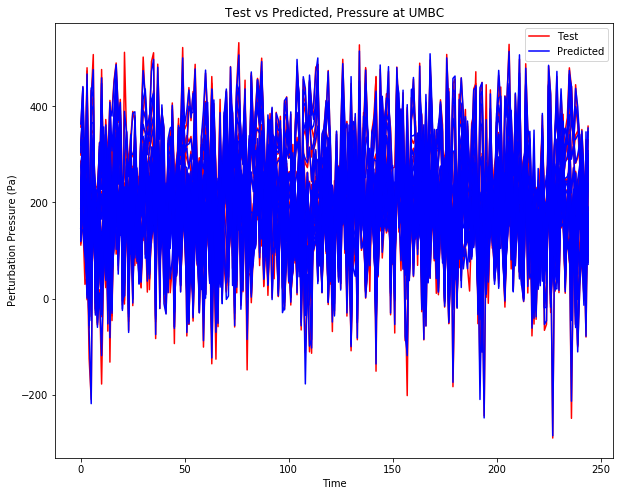

In [43]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Pressure at UMBC')
plt.xlabel('Time')
plt.ylabel('Perturbation Pressure (Pa)')
plt.plot(y_test_p, 'r',label='Test')
plt.plot(predicted_p, 'b',label='Predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.legend()
plt.savefig('images_data/Pressure for UMBC Location.png')
plt.show()

### The plot looks convencing as almost all test data points are covered by predicted data. To get a closer look lets plot the single time and location

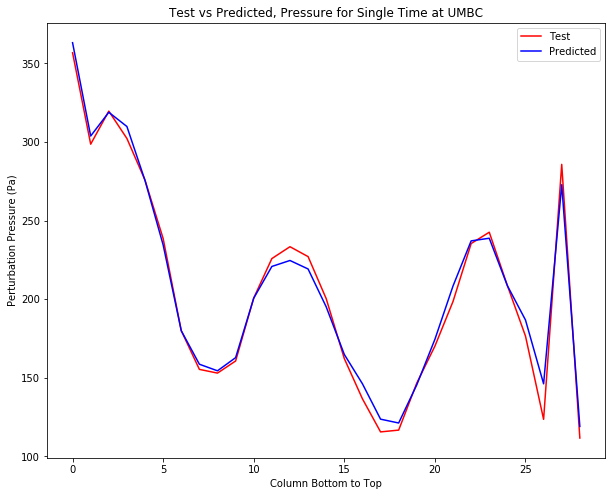

In [45]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Pressure for Single Time at UMBC')
plt.xlabel('Column Bottom to Top')
plt.ylabel('Perturbation Pressure (Pa)')
plt.plot(y_test_p[0], 'r', label='Test')
plt.plot(predicted_p[0], 'b', Label = 'Predicted')
plt.legend()
plt.savefig('images_data/Pressure for Single Time at UMBC_0.png')
plt.show()

### Export the model to save the config

In [73]:
model_p = auto_model_p.export_model()

### Saving the trained model with weights to make further predictions

In [76]:
try:
    model_p.save("Model_save/model_autokeras_pressure_UMBC", save_format="tf")
except Exception:
    model_p.save("Model_save/model_autokeras_pressure_UMBC.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_save/model_autokeras_pressure_UMBC/assets


### Saving the Model Architecture Configurations

In [78]:
f = open("images_data/Pressure_Model_config_UMBC.txt", "w")
f.write(str(model_p.get_config()))
f.close()